In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import c as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

In [3]:
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [4]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


# Class Imbalance:

In [5]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [6]:
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [7]:
rowsums

0         0
1         0
2         0
3         0
4         0
5         0
6         4
7         0
8         0
9         0
10        0
11        0
12        1
13        0
14        0
15        0
16        1
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
159541    3
159542    0
159543    0
159544    0
159545    0
159546    2
159547    0
159548    0
159549    0
159550    0
159551    0
159552    0
159553    0
159554    3
159555    0
159556    0
159557    0
159558    0
159559    0
159560    0
159561    0
159562    0
159563    0
159564    0
159565    0
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

In [8]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


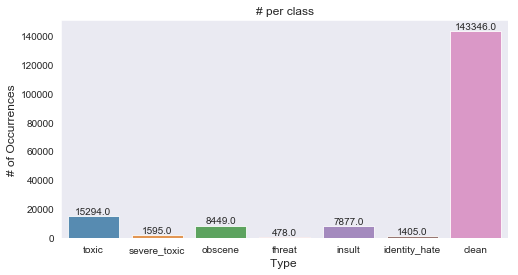

In [9]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems

-There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!?

-This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.

# Multi-tagging:

Let's check how many comments have multiple tags.

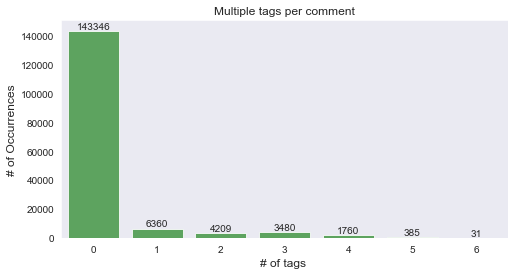

In [10]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [11]:
x

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

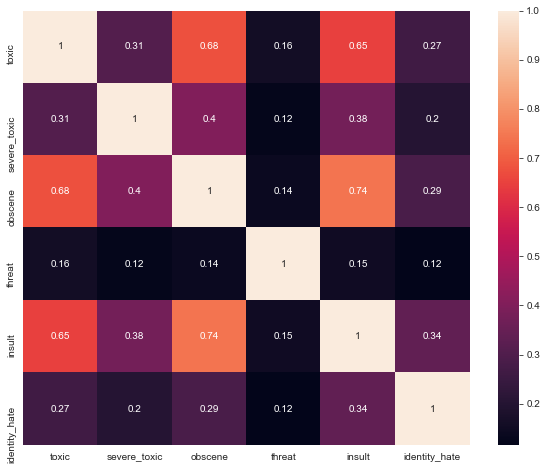

In [12]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we can use other tools like

Confusion matrix/Crosstab

Cramer's V Statistic

Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured

In [13]:
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
#out = out.style.apply(highlight_min,axis=0)
out

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.

Some interesting observations:

A Severe toxic comment is always toxic

Other classes seem to be a subset of toxic barring a few exceptions

In [14]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [15]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614


Example Comments:

In [16]:
print("toxic:")
print(train[train.toxic==1].iloc[2,1])

toxic:
Bye! 

Don't look, come or think of comming back! Tosser.


In [17]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [18]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [19]:
print("Obscene:")
#print(train[train.obscene==1])
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [20]:
 train[train.obscene==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,False
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,False
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,False
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,False
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,False


That was a whole lot of toxicity. Some weird observations:

Some of the comments are extremely and mere copy paste of the same thing

Comments can still contain IP addresses(eg:62.158.73.165), usernames(eg:ARKJEDI10) and some mystery numbers(i assume is article-IDs)

Point 2 can cause huge overfitting.

# Wordclouds - Frequent words:

Now, let's take a look at words that are associated with these classes.

Chart Desc: The visuals here are word clouds (ie) more frequent words appear bigger. A cool way to create word clouds with funky pics is given here. It involves the following steps.

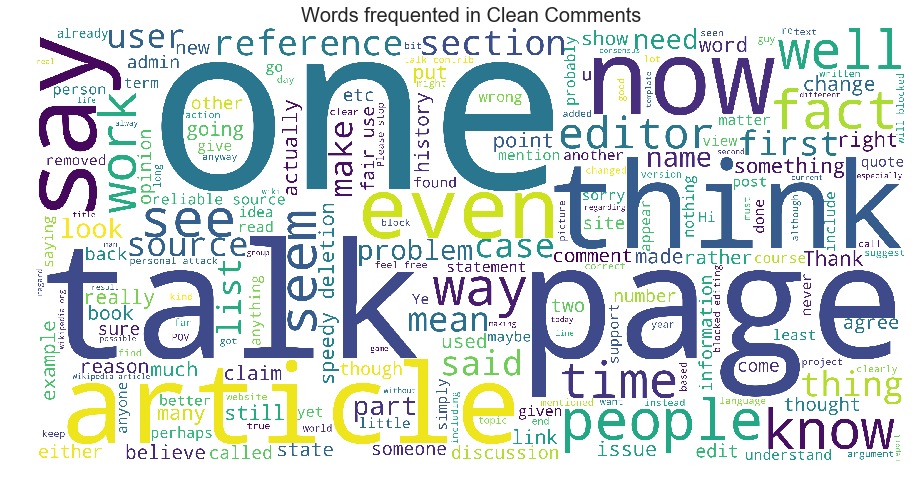

In [21]:
#clean comments
#clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
#clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
#df_toxic['comment_text']=df_toxic['comment_text'].astype(str)
subset=train[train.clean==True]
toxic_corpus=' '.join(subset.comment_text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(toxic_corpus)
plt.figure(figsize=(16,8))
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

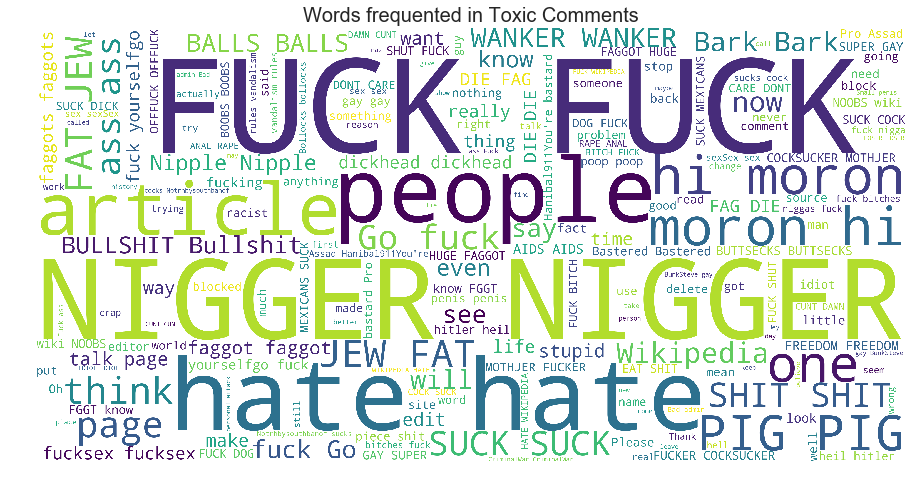

In [22]:
subset=train[train.toxic==1]
toxic_corpus=' '.join(subset.comment_text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(toxic_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.axis('off')
plt.show()

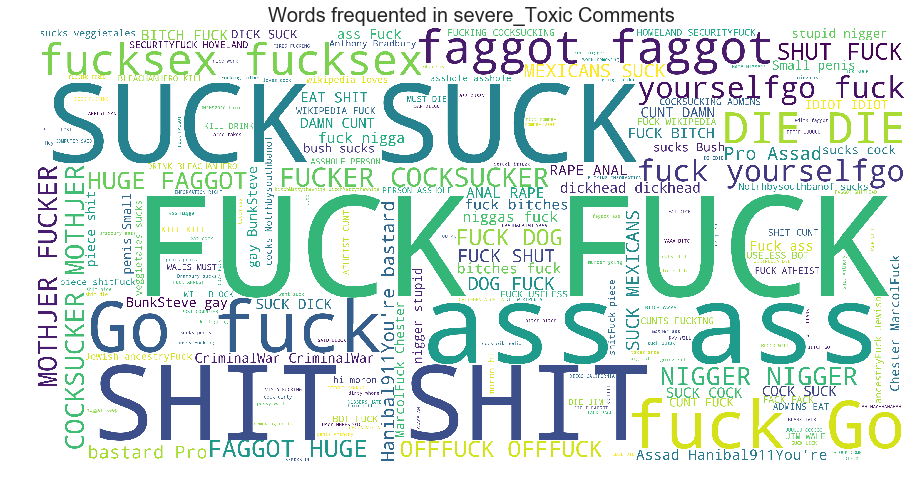

In [23]:
subset=train[train.severe_toxic==1]
toxic_corpus=' '.join(subset.comment_text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(toxic_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in severe_Toxic Comments", fontsize=20)
plt.axis('off')
plt.show()

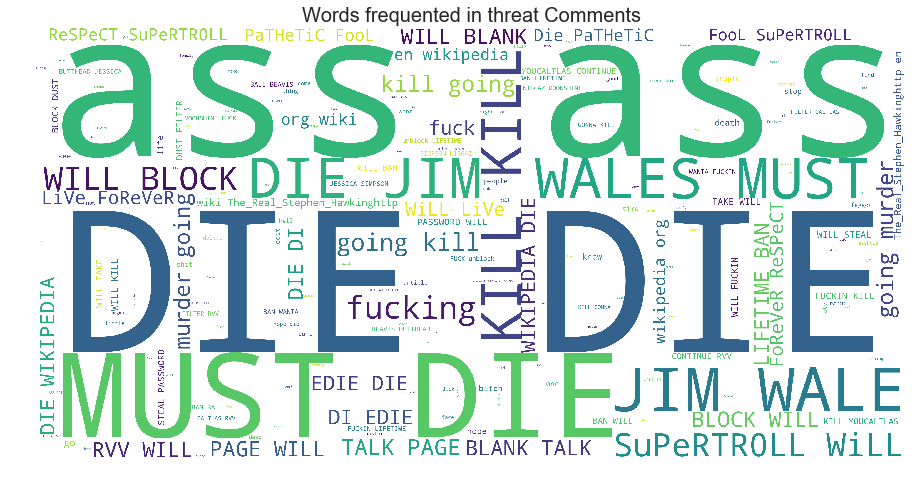

In [24]:
subset=train[train.threat==1]
toxic_corpus=' '.join(subset.comment_text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(toxic_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in threat Comments", fontsize=20)
plt.axis('off')
plt.show()

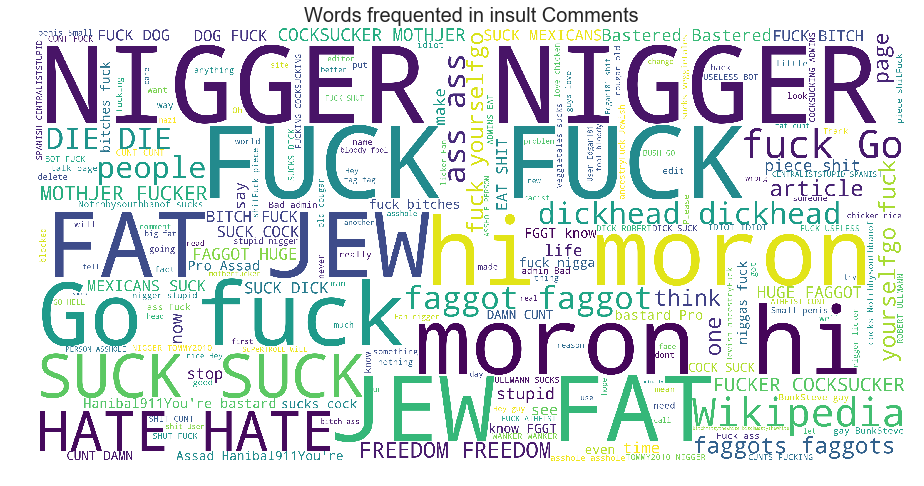

In [25]:
subset=train[train.insult==1]
toxic_corpus=' '.join(subset.comment_text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(toxic_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in insult Comments", fontsize=20)
plt.axis('off')
plt.show()

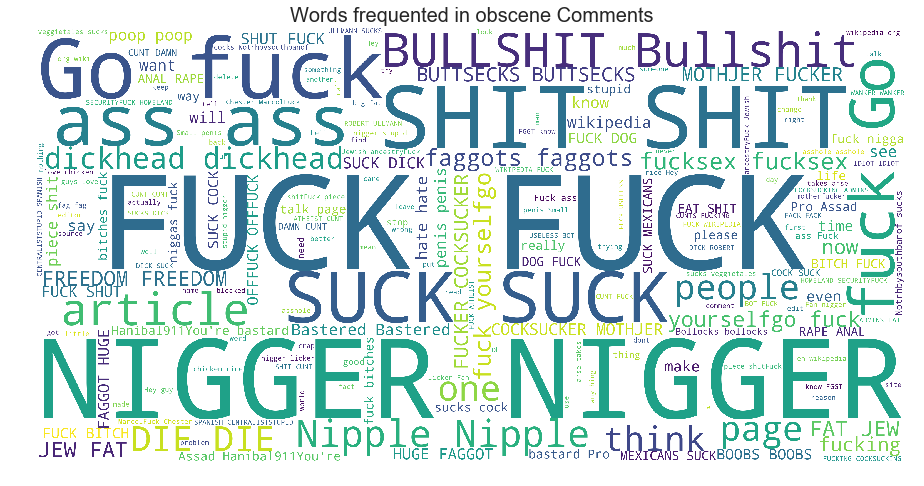

In [26]:
subset=train[train.obscene==1]
toxic_corpus=' '.join(subset.comment_text.values)
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(toxic_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.title("Words frequented in obscene Comments", fontsize=20)
plt.axis('off')
plt.show()


# Feature engineering:

I've broadly classified my feature engineering ideas into the following three groups

# Direct features

Features which are a directly due to words/content.We would be exploring the following techniques

Word frequency features

Count features

Bigrams

Trigrams

Vector distance mapping of words (Eg: Word2Vec)

Sentiment scores

# Indirect features:

Some more experimental features.

count of sentences

count of words

count of unique words

count of letters

count of punctuations

count of uppercase words/letters

count of stop words

Avg length of each word

# Leaky features:

From the example, we know that the comments contain identifier information (eg: IP, username,etc.). We can create features out of them but, it will certainly lead to overfitting to this specific Wikipedia use-case.

toxic IP scores

toxic users

Note: Creating the indirect and leaky features first. There are two reasons for this,

Count features(Direct features) are useful only if they are created from a clean corpus
Also the indirect features help compensate for the loss of information when cleaning the dataset

In [27]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)
#df

In [28]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [29]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [30]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [31]:
train_feats.head()

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538,0,0,0,0,0,0,True


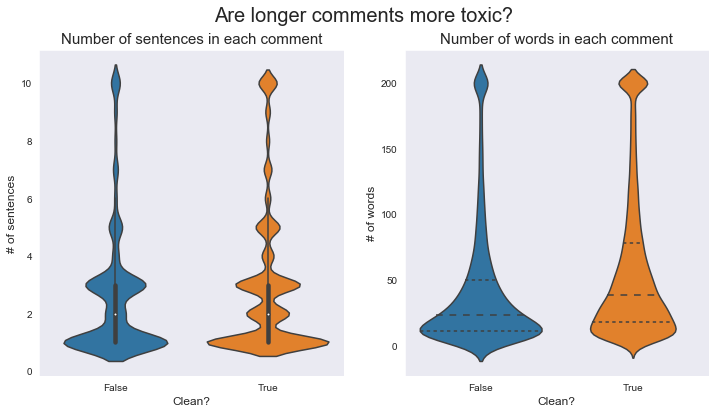

In [32]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

In [33]:
train_feats['count_unique_word'].head()

0    41
1    17
2    39
3    82
4    13
Name: count_unique_word, dtype: int64

In [34]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

In [35]:
temp_df.head()

,clean,variable,value
0,True,count_word,43
1,True,count_word,17
2,True,count_word,42
3,True,count_word,113
4,True,count_word,13


In [36]:
spammers.head(3)

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
1043,02d9ff88fc2893c8,"""\n\nOrphaned non-free image (Image:KSV Hessen...",10,200,132,3820,146,0,59,306,4.884080,20.401855,22.565688,0,0,0,0,0,0,True
1876,0512b588a4b80e45,YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!...,10,96,20,4897,200,78,7,33,50.000000,20.833333,208.333333,1,0,1,0,1,1,False
2249,06168775082a96d2,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A...,1,200,6,2885,78,468,78,234,5.166667,1.282051,16.666667,1,1,1,0,1,0,False


In [37]:
x=spammers.iloc[:,-7:]
x.head(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
1043,0,0,0,0,0,0,True
1876,1,0,1,0,1,1,False
2249,1,1,1,0,1,0,False
2366,1,0,1,0,1,1,False
2420,1,1,1,0,1,0,False


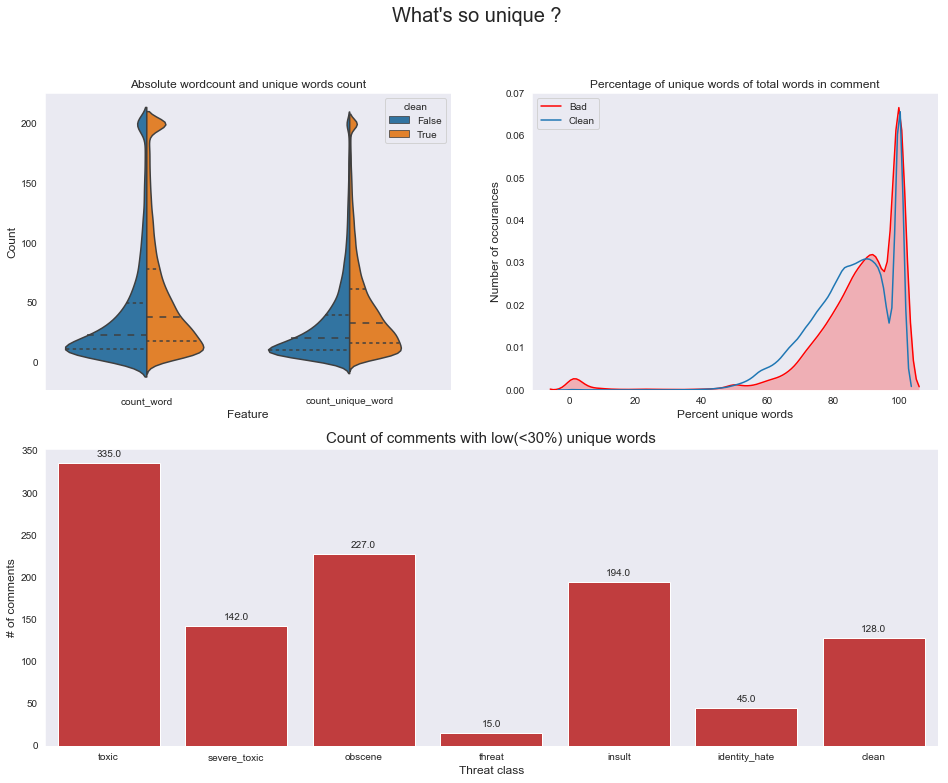

In [38]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

Word count VS unique word count:

    There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.

Unique word count percent:
    
    There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words

Even though the number of clean comments dominates the dataset(~90%), there are only 128 clean comments that are spam, which makes it a powerful indicator of a toxic comment.

# Spammers are more toxic!

No surprises here. Let's take a look at some clean and toxic spam messages

In [39]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

# Spam is toxic to the model too!


These spam entries are bad if we design our model to contain normal word counts features. Imagine the scenario in which our model picked up the words "mitt romney" from any comment and classified it as toxic :(

# Leaky features

Caution: Even-though including these features might help us perform better in this particular scenario, it will not make sence to add them in the final model/general purpose model.

Here we are creating our own custom count vectorizer to create count variables that match our regex condition.

In [40]:
#Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

#username
##              regex for     Match anything with [[User: ---------- ]]
# regexp = re.compile("\[\[User:(.*)\|")
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))
#check if features are created
#df.username[df.count_usernames>0]

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [41]:
df[df.count_usernames!=0].comment_text.iloc[2]

'[[User_Talk:King Lopez|Lopez]]Contribs'

In [42]:
cv.get_feature_names()[120:130]

['destruction',
 'diablo',
 'diligent',
 'dland',
 'dlohcierekim',
 'dodo',
 'dominick',
 'douglas',
 'dpl',
 'dr']

In [43]:
count_feats_user 

<312735x360 sparse matrix of type '<class 'numpy.int64'>'
	with 718 stored elements in Compressed Sparse Row format>

# Leaky Feature Stability:

Checking the re-occurance of leaky features to check their utility in predicting the test set.

In [44]:
leaky_feats=df[["ip","link","article_id","username","count_ip","count_links","count_usernames","article_id_flag"]]
leaky_feats_train=leaky_feats.iloc[:train.shape[0]]
leaky_feats_test=leaky_feats.iloc[train.shape[0]:]

In [45]:
leaky_feats.head()

,ip,link,article_id,username,count_ip,count_links,count_usernames,article_id_flag
0,[89.205.38.27],[],[],[],1,0,0,0
1,[],[],[],[],0,0,0,0
2,[],[],[],[],0,0,0,0
3,[],[],[],[],0,0,0,0
4,[],[],[],[],0,0,0,0


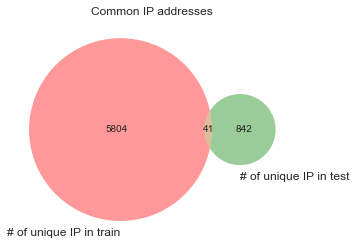

In [46]:
import c as venn
import matplotlib_venn as venn
#filterout the entries without ips
train_ips=leaky_feats_train.ip[leaky_feats_train.count_ip!=0]
test_ips=leaky_feats_test.ip[leaky_feats_test.count_ip!=0]
#get the unique list of ips in test and train datasets
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
common_ip_list=list(set(train_ip_list).intersection(test_ip_list))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_ip_list),len(test_ip_list),len(common_ip_list)),set_labels=("# of unique IP in train","# of unique IP in test"))
plt.show()

In [47]:
train_ip_list

['186.205.17.133',
 '2.120.85.89',
 '145.120.15.192',
 '68.42.27.164',
 '90.219.222.144',
 '5.134.117.171',
 '75.80.128.139',
 '1.214.81.081',
 '164.100.24.208',
 '92.11.47.205',
 '118.21.142.128',
 '72.11.138.103',
 '130.234.5.136',
 '192.115.144.0',
 '206.255.16.234',
 '83.227.233.10',
 '123.62.6.58',
 '217.72.91.120',
 '177.154.145.107',
 '71.128.53.204',
 '69.250.151.110',
 '76.7.95.112',
 '66.97.209.215',
 '93.161.107.169',
 '74.60.255.254',
 '94.1.77.132',
 '81.100.44.233',
 '24.184.169.37',
 '24.44.61.108',
 '202.86.135.18',
 '80.42.3.248',
 '99.165.226.1',
 '87.162.47.181',
 '69.115.226.11',
 '201.68.139.99',
 '84.23.140.26',
 '173.104.94.253',
 '62.177.225.138',
 '69.112.55.255',
 '212.85.15.82',
 '208.58.79.184',
 '91.100.100.12',
 '128.163.242.6',
 '76.224.19.21',
 '92.4.216.135',
 '86.182.64.127',
 '66.206.186.59',
 '66.38.55.135',
 '76.211.26.1',
 '67.76.14.136',
 '69.154.191.30',
 '66.81.255.162',
 '24.144.170.57',
 '97.102.153.253',
 '75.75.180.0',
 '82.6.168.150',
 '24.

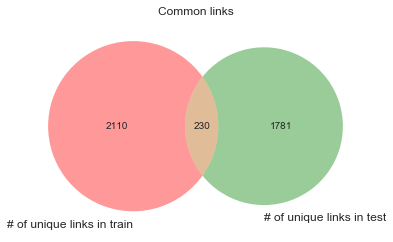

In [48]:
#filterout the entries without links
train_links=leaky_feats_train.link[leaky_feats_train.count_links!=0]
test_links=leaky_feats_test.link[leaky_feats_test.count_links!=0]
#get the unique list of ips in test and train datasets
train_links_list=list(set([a for b in train_links.tolist() for a in b]))
test_links_list=list(set([a for b in test_links.tolist() for a in b]))

# get common elements
common_links_list=list(set(train_links_list).intersection(test_links_list))
plt.title("Common links")
venn.venn2(subsets=(len(train_links_list),len(test_links_list),len(common_links_list)),
           set_labels=("# of unique links in train","# of unique links in test"))
plt.show()

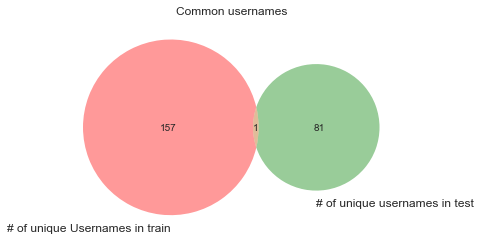

In [49]:
#filterout the entries without users
train_users=leaky_feats_train.username[leaky_feats_train.count_usernames!=0]
test_users=leaky_feats_test.username[leaky_feats_test.count_usernames!=0]
#get the unique list of ips in test and train datasets
train_users_list=list(set([a for b in train_users.tolist() for a in b]))
test_users_list=list(set([a for b in test_users.tolist() for a in b]))

# get common elements
common_users_list=list(set(train_users_list).intersection(test_users_list))
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique Usernames in train","# of unique usernames in test"))
plt.show()

In [50]:
#https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

blocked_ips=["216.102.6.176",
"216.120.176.2",
"203.25.150.5",
"203.217.8.30",
"66.90.101.58",
"125.178.86.75",
"210.15.217.194",
"69.36.166.207",
"213.25.24.253",
"24.60.181.235",
"71.204.14.32",
"216.91.92.18",
"212.219.2.4",
"194.74.190.162",
"64.15.152.246",
"59.100.76.166",
"146.145.221.129",
"146.145.221.130",
"74.52.44.34",
"68.5.96.201",
"65.184.176.45",
"209.244.43.209",
"82.46.9.168",
"209.200.236.32",
"209.200.229.181",
"202.181.99.22",
"220.233.226.170",
"212.138.64.178",
"220.233.227.249",
"72.14.194.31",
"72.249.45.0/24",
"72.249.44.0/24",
"80.175.39.213",
"81.109.164.45",
"64.157.15.0/24",
"208.101.10.54",
"216.157.200.254",
"72.14.192.14",
"204.122.16.13",
"217.156.39.245",
"210.11.188.16",
"210.11.188.17",
"210.11.188.18",
"210.11.188.19",
"210.11.188.20",
"64.34.27.153",
"209.68.139.150",
"152.163.100.0/24",
"65.175.48.2",
"131.137.245.197",
"131.137.245.199",
"131.137.245.200",
"64.233.172.37",
"66.99.182.25",
"67.43.21.12",
"66.249.85.85",
"65.175.134.11",
"201.218.3.198",
"193.213.85.12",
"131.137.245.198",
"83.138.189.74",
"72.14.193.163",
"66.249.84.69",
"209.204.71.2",
"80.217.153.189",
"83.138.136.92",
"83.138.136.91",
"83.138.189.75",
"83.138.189.76",
"212.100.250.226"
"212.100.250.225",
"212.159.98.189",
"87.242.116.201",
"74.53.243.18",
"213.219.59.96/27",
"212.219.82.37",
"203.38.149.226",
"66.90.104.22",
"125.16.137.130",
"66.98.128.0/17",
"217.33.236.2",
"24.24.200.113",
"152.22.0.254",
"59.145.89.17",
"71.127.224.0/20",
"65.31.98.71",
"67.53.130.69",
"204.130.130.0/24",
"72.14.193.164",
"65.197.143.214",
"202.60.95.235",
"69.39.89.95",
"88.80.215.14",
"216.218.214.2",
"81.105.175.201",
"203.108.239.12",
"74.220.207.168",
"206.253.55.206",
"206.253.55.207",
"206.253.55.208",
"206.253.55.209",
"206.253.55.210",
"66.64.56.194",
"70.91.90.226",
"209.60.205.96",
"202.173.191.210",
"169.241.10.83",
"91.121.195.205",
"216.70.136.88",
"72.228.151.208",
"66.197.167.120",
"212.219.232.81",
"208.86.225.40",
"63.232.20.2",
"206.219.189.8",
"212.219.14.0/24",
"165.228.71.6",
"99.230.151.129",
"72.91.11.99",
"173.162.177.53",
"60.242.166.182",
"212.219.177.34",
"12.104.27.5",
"85.17.92.13",
"91.198.174.192/27",
"155.246.98.61",
"71.244.123.63",
"81.144.152.130",
"198.135.70.1",
"71.255.126.146",
"74.180.82.59",
"206.158.2.80",
"64.251.53.34",
"24.29.92.238",
"76.254.235.105",
"68.96.242.239",
"203.202.234.226",
"173.72.89.88",
"87.82.229.195",
"68.153.245.37",
"216.240.128.0/19",
"72.46.129.44",
"66.91.35.165",
"82.71.49.124",
"69.132.171.231",
"75.145.183.129",
"194.80.20.237",
"98.207.253.170",
"76.16.222.162",
"66.30.100.130",
"96.22.29.23",
"76.168.140.158",
"202.131.166.252",
"89.207.212.99",
"81.169.155.246",
"216.56.8.66",
"206.15.235.10",
"115.113.95.20",
"204.209.59.11",
"27.33.141.67",
"41.4.65.162",
"99.6.65.6",
"60.234.239.169",
"2620:0:862:101:0:0:2:0/124",
"183.192.165.31",
"50.68.6.12",
"37.214.82.134",
"96.50.0.230",
"60.231.28.109",
"64.90.240.50",
"49.176.97.12",
"209.80.150.137",
"24.22.67.116",
"206.180.81.2",
"195.194.39.100",
"87.41.52.6",
"169.204.164.227",
"50.137.55.117",
"50.77.84.161",
"90.202.230.247",
"186.88.129.224",
"2A02:EC80:101:0:0:0:2:0/124",
"142.4.117.177",
"86.40.105.198",
"120.43.20.149",
"198.199.64.0/18",
"192.34.56.0/21",
"192.81.208.0/20",
"2604:A880:0:0:0:0:0:0/32",
"108.72.107.229",
"2602:306:CC2B:7000:41D3:B92D:731C:959D",
"185.15.59.201",
"180.149.1.229",
"207.191.188.66",
"210.22.63.92",
"117.253.196.217",
"119.160.119.172",
"90.217.133.223",
"194.83.8.3",
"194.83.164.22",
"217.23.228.149",
"65.18.58.1",
"168.11.15.2",
"65.182.127.31",
"207.106.153.252",
"64.193.88.2",
"152.26.71.2",
"199.185.67.179",
"117.90.240.73",
"108.176.58.170",
"195.54.40.28",
"185.35.164.109",
"192.185.0.0/16",
"2605:E000:1605:C0C0:3D3D:A148:3039:71F1",
"107.158.0.0/16",
"85.159.232.0/21",
"69.235.4.10",
"86.176.166.206",
"108.65.152.51",
"10.4.1.0/24",
"103.27.227.139",
"188.55.31.191",
"188.53.13.34",
"176.45.58.252",
"176.45.22.37",
"24.251.44.140",
"108.200.140.191",
"117.177.169.4",
"72.22.162.38",
"24.106.242.82",
"79.125.190.93",
"107.178.200.1",
"123.16.244.246",
"83.228.167.87",
"128.178.197.53",
"14.139.172.18",
"207.108.136.254",
"184.152.17.217",
"186.94.29.73",
"217.200.199.2",
"66.58.141.104",
"166.182.81.30",
"89.168.206.116",
"92.98.163.145",
"77.115.31.71",
"178.36.118.74",
"157.159.10.14",
"103.5.212.139",
"203.174.180.226",
"69.123.252.95",
"199.200.123.233",
"121.45.89.82",
"71.228.87.155",
"68.189.67.92",
"216.161.176.152",
"98.17.30.139",
"2600:1006:B124:84BD:0:0:0:103",
"117.161.0.0/16",
"12.166.68.34",
"96.243.149.64",
"74.143.90.218",
"76.10.176.221",
"104.250.128.0/19",
"185.22.183.128/25",
"89.105.194.64/26",
"202.45.119.0/24",
"73.9.140.64",
"164.127.71.72",
"50.160.129.2",
"49.15.213.207",
"83.7.192.0/18",
"201.174.63.79",
"2A02:C7D:4643:8F00:D09D:BE1:D2DE:BB1F",
"125.60.195.230",
"49.145.113.145",
"168.18.160.134",
"72.193.218.222",
"199.216.164.10",
"120.144.130.89",
"104.130.67.208",
"50.160.221.147",
"163.47.141.50",
"91.200.12.136",
"83.222.0.0/19",
"67.231.16.0/20",
"72.231.0.196",
"180.216.68.197",
"183.160.178.135",
"183.160.176.16",
"24.25.221.150",
"92.222.109.43",
"142.134.243.215",
"216.181.221.72",
"113.205.170.110",
"74.142.2.98",
"192.235.8.3",
"2402:4000:BBFC:36FC:E469:F2F0:9351:71A0",
"80.244.81.191",
"2607:FB90:1377:F765:D45D:46BF:81EA:9773",
"2600:1009:B012:7D88:418B:54BA:FCBC:4584",
"104.237.224.0/19",
"2600:1008:B01B:E495:C05A:7DD3:926:E83C",
"168.8.249.234",
"162.211.179.36",
"138.68.0.0/16",
"145.236.37.195",
"67.205.128.0/18",
"2A02:C7D:2832:CE00:B914:19D6:948D:B37D",
"107.77.203.212",
"2607:FB90:65C:A136:D46F:23BA:87C2:3D10",
"2A02:C7F:DE2F:7900:5D64:E991:FFF0:FA93",
"82.23.32.186",
"106.76.243.74",
"82.33.48.223",
"180.216.160.0/19",
"94.102.184.35",
"94.102.184.26",
"109.92.162.54",
"2600:8800:7180:BF00:4C27:4591:347C:736C",
"178.41.186.50",
"184.97.134.128",
"176.221.32.0/22",
"207.99.40.142",
"109.97.241.134",
"82.136.64.19",
"91.236.74.119",
"197.210.0.0/16",
"173.230.128.0/19",
"162.216.16.0/22",
"80.111.222.211",
"191.37.28.21",
"124.124.103.194",
"50.207.7.198",
"220.233.131.98",
"107.77.241.11",
"68.112.39.0/27",
"173.236.128.0/17",
"49.49.240.24",
"96.31.10.178",
"50.251.229.75"]

In [51]:
train_ip_list=list(set([a for b in train_ips.tolist() for a in b]))
test_ip_list=list(set([a for b in test_ips.tolist() for a in b]))

# get common elements
blocked_ip_list_train=list(set(train_ip_list).intersection(blocked_ips))
blocked_ip_list_test=list(set(test_ip_list).intersection(blocked_ips))

print("There are",len(blocked_ip_list_train),"blocked IPs in train dataset")
print("There are",len(blocked_ip_list_test),"blocked IPs in test dataset")

There are 6 blocked IPs in train dataset
There are 0 blocked IPs in test dataset


An interesting but somewhat insignificant finding. There are 6 blocked IP mentions in the comments overall.

Anyways, moving on to cleaning the dataset.

In [52]:
end_time=time.time()
print("total time till Leaky feats",end_time-start_time)

total time till Leaky feats 202.70641136169434


# Corpus cleaning:

In [53]:
corpus=merge.comment_text

In [54]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [55]:

def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)


In [56]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [57]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 358.287157535553


# Direct features:

# 1)Count based features(for unigrams):

Lets create some features based on frequency distribution of the words. Initially lets consider taking words one at a time (ie) Unigrams

Python's SKlearn provides 3 ways of creating count features.All three of them first create a vocabulary(dictionary) of words and then create a sparse matrix of word counts for the words in the sentence that are present in the dictionary. A brief description of them:

CountVectorizer

Creates a matrix with frequency counts of each word in the text corpus

TF-IDF Vectorizer

TF - Term Frequency -- Count of the words(Terms) in the text corpus (same of Count Vect)

IDF - Inverse Document Frequency -- Penalizes words that are too frequent. We can think of this as regularization

HashingVectorizer

Creates a hashmap(word to number mapping based on hashing technique) instead of a dictionary for vocabulary
This enables it to be more scalable and faster for larger text coprus
Can be parallelized across multiple threads

In [58]:
### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [59]:
train_unigrams

<159571x3914 sparse matrix of type '<class 'numpy.float64'>'
	with 2994581 stored elements in Compressed Sparse Row format>

In [60]:
train_tags.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0,0,0,0,0,0,True
1,0,0,0,0,0,0,True
2,0,0,0,0,0,0,True
3,0,0,0,0,0,0,True
4,0,0,0,0,0,0,True


In [61]:
features

array(['00', '000', '000000', ..., 'zero', 'zionist', 'zone'],
      dtype='<U16')

In [62]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [63]:
#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

end_unigrams=time.time()

print("total time in unigrams",end_unigrams-start_unigrams)
print("total time till unigrams",end_unigrams-start_time)

total time in unigrams 98.62211656570435
total time till unigrams 456.92124128341675


In [64]:
tfidf_top_n_per_lass

[      feature     tfidf
 0        fuck  0.082641
 1        shit  0.024963
 2        suck  0.022605
 3        like  0.019794
 4       bitch  0.019045
 5         ass  0.018233
 6      stupid  0.017461
 7        stop  0.017323
 8   wikipedia  0.016437
 9       block  0.016315
 10       page  0.015080
 11    asshole  0.014594
 12      idiot  0.013953
 13       edit  0.013859
 14       know  0.013807
 15     faggot  0.013728
 16        gay  0.013621
 17       dick  0.013270
 18       life  0.012913
 19       hell  0.012560,
          feature     tfidf
 0           fuck  0.242535
 1          bitch  0.058155
 2           suck  0.053138
 3           shit  0.050818
 4            ass  0.040283
 5        asshole  0.037122
 6           dick  0.035723
 7         faggot  0.032441
 8           cunt  0.031750
 9           cock  0.024802
 10        fucker  0.019032
 11         piece  0.018783
 12           die  0.018254
 13           gay  0.017875
 14        stupid  0.017689
 15        mother  0.01734

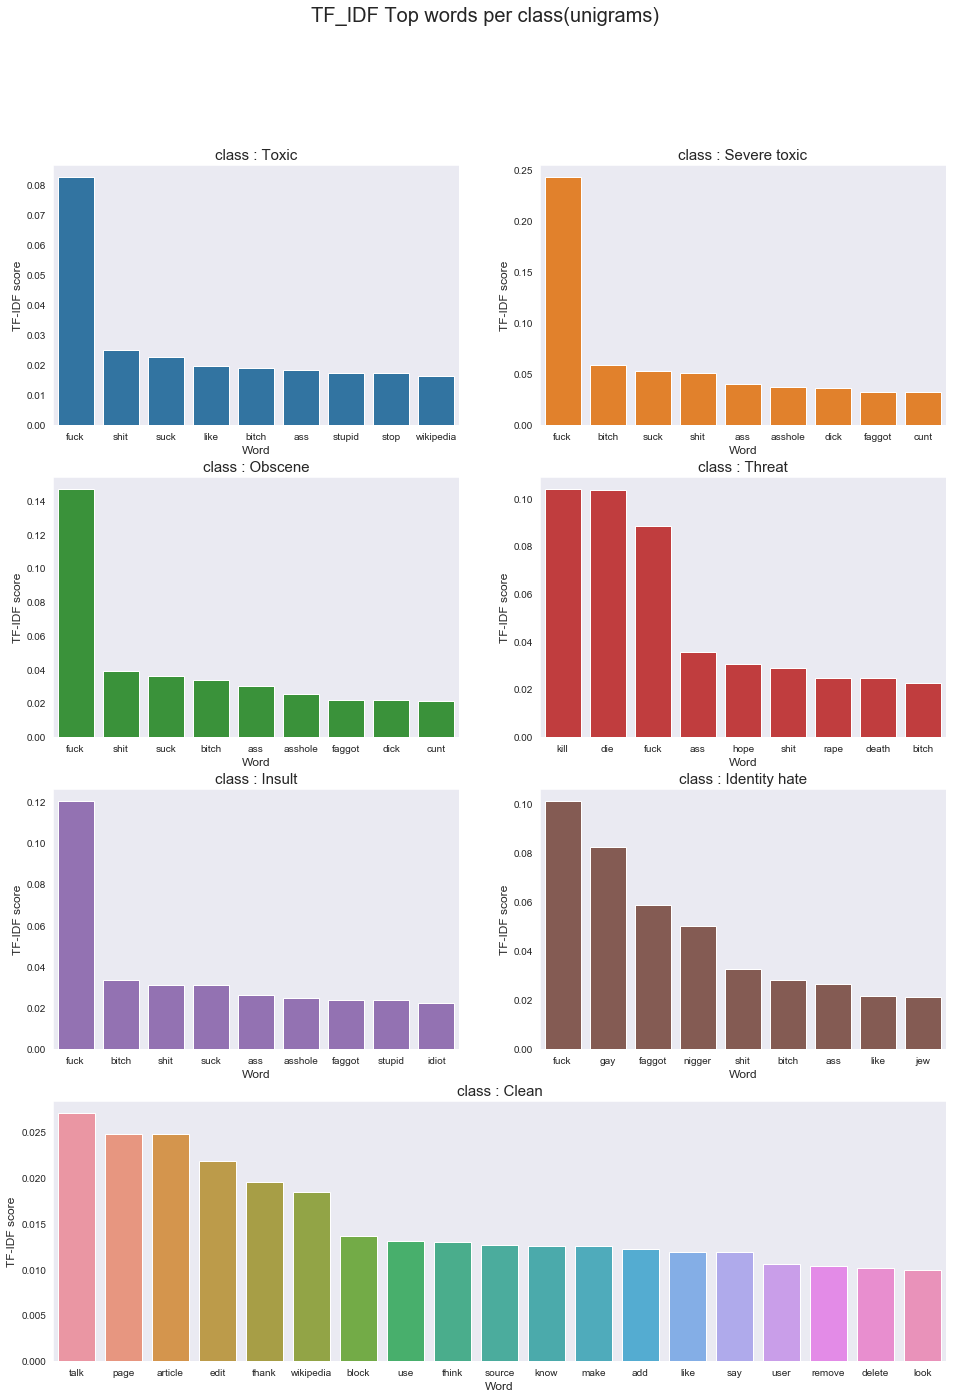

In [65]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [66]:
#temp settings to min=150 to facilitate top features section to run in kernals
#change back to min=10 to get better results
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

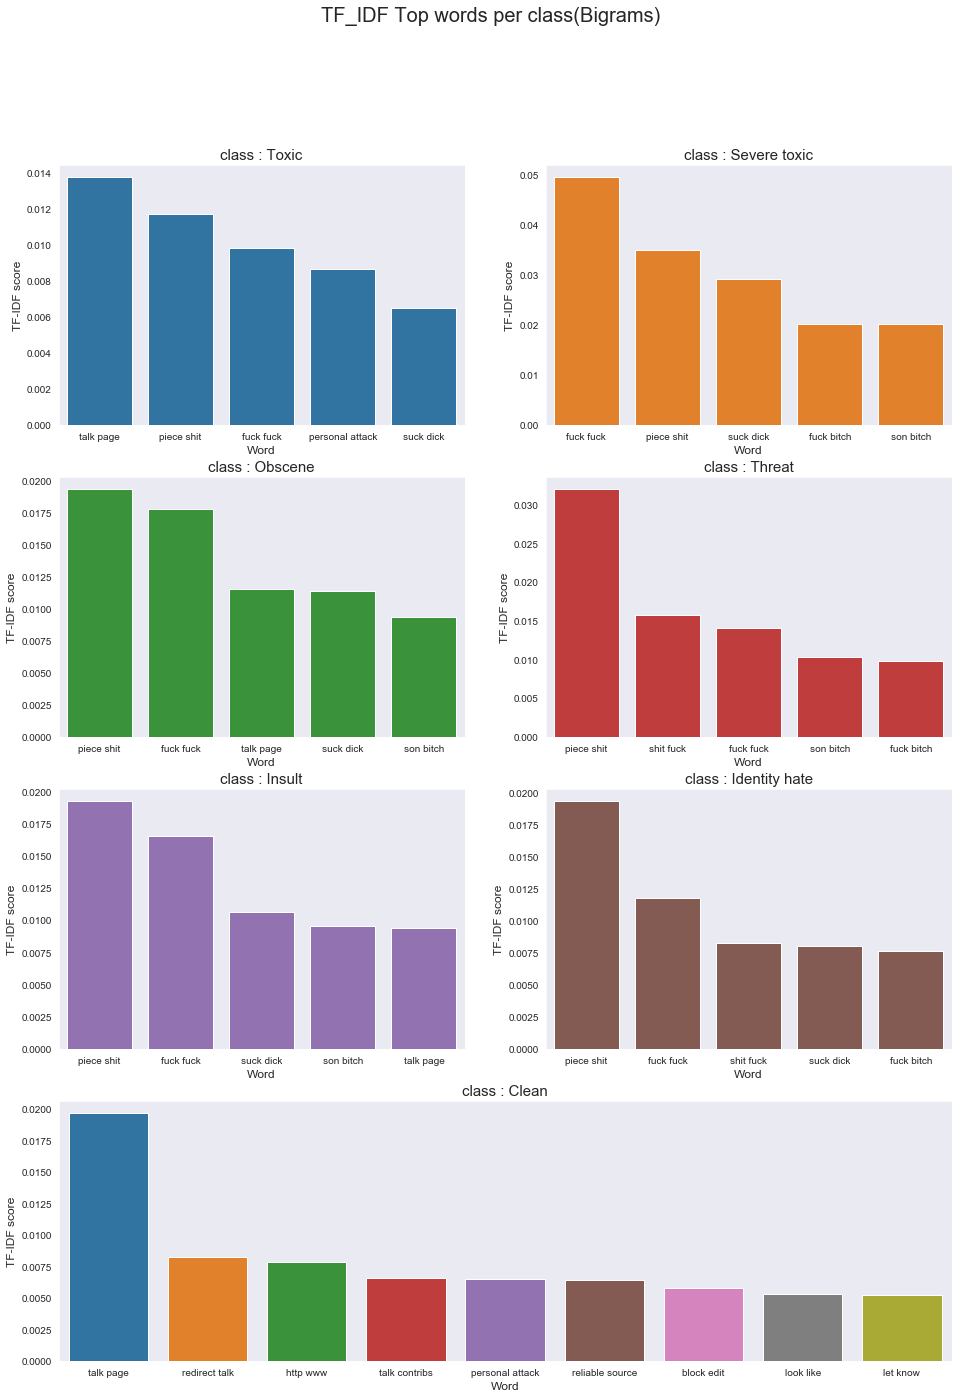

In [67]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()


In [68]:
end_time=time.time()
print("total time till bigrams",end_time-start_time)

total time till bigrams 524.9327299594879


In [69]:
tfv = TfidfVectorizer(min_df=100,  max_features=30000, 
            strip_accents='unicode', analyzer='char',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_charngrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
end_time=time.time()
print("total time till charngrams",end_time-start_time)

total time till charngrams 848.1043999195099


# Baseline Model:

In [70]:
#Credis to AlexSanchez https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316
#custom NB model

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    
# model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)

In [71]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]
# target_x

TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train_tags[TARGET_COLS]

# Strat k fold due to imbalanced classes
# split = StratifiedKFold(n_splits=2, random_state=1)

#https://www.kaggle.com/yekenot/toxic-regression

In [72]:
train_feats

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714,0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071,0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538,0,0,0,0,0,0,True
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",3,13,12,65,4,0,1,4,3.923077,92.307692,30.769231,0,0,0,0,0,0,True
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,8,8,44,0,8,0,4,4.625000,100.000000,0.000000,1,1,1,0,1,0,False
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,1,20,20,115,4,0,4,12,4.750000,100.000000,20.000000,0,0,0,0,0,0,True
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,1,83,70,472,19,1,5,42,4.698795,84.337349,22.891566,0,0,0,0,0,0,True
9,00040093b2687caa,alignment on this subject and which are contra...,1,12,12,70,0,0,0,8,4.916667,100.000000,0.000000,0,0,0,0,0,0,True


In [73]:
target_x

,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
1,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
2,1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
3,5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
4,1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538
5,3,13,12,65,4,0,1,4,3.923077,92.307692,30.769231
6,1,8,8,44,0,8,0,4,4.625000,100.000000,0.000000
7,1,20,20,115,4,0,4,12,4.750000,100.000000,20.000000
8,1,83,70,472,19,1,5,42,4.698795,84.337349,22.891566
9,1,12,12,70,0,0,0,8,4.916667,100.000000,0.000000


In [75]:
#Just the indirect features -- meta features
#I had to reduce the sample size, so as to save the code from Memory Error.
print("Using only Indirect features")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train[0:30000].shape[0], len(y_train[0:30000])))
preds_valid = np.zeros((X_valid[0:10000].shape[0], len(y_valid[0:10000])))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid[0:10000])[:,1]
    preds_train[:,i] = model.predict_proba(X_train[0:30000])[:,1]
    train_loss_class=log_loss(y_train[0:30000][j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[0:10000][j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("total time till Indirect feat model",end_time-start_time)

Using only Indirect features
Class:= toxic
Trainloss=log loss: 0.30389894966857556
Validloss=log loss: 0.2991536145023335
Class:= severe_toxic
Trainloss=log loss: 0.05177836116045087
Validloss=log loss: 0.05578636290901153
Class:= obscene
Trainloss=log loss: 0.19917827056165469
Validloss=log loss: 0.19097505478945023
Class:= threat
Trainloss=log loss: 0.02021150489954843
Validloss=log loss: 0.018524045762272713
Class:= insult
Trainloss=log loss: 0.18885416128119453
Validloss=log loss: 0.18761660642824604
Class:= identity_hate
Trainloss=log loss: 0.04599083255721273
Validloss=log loss: 0.05464711982042271
mean column-wise log loss:Train dataset 0.13498534668810613
mean column-wise log loss:Validation dataset 0.1344504673686228
total time till Indirect feat model 1009.0934672355652


In [76]:
importance[0][0]

array([ 3.07367983e-02, -4.93406881e-03, -1.79371648e-02,  2.20761304e-04,
        1.35973140e-03,  4.98967410e-02, -1.85167162e-02,  3.80054327e-03,
       -2.40018043e-03, -1.80709692e-02, -1.74577997e-05])

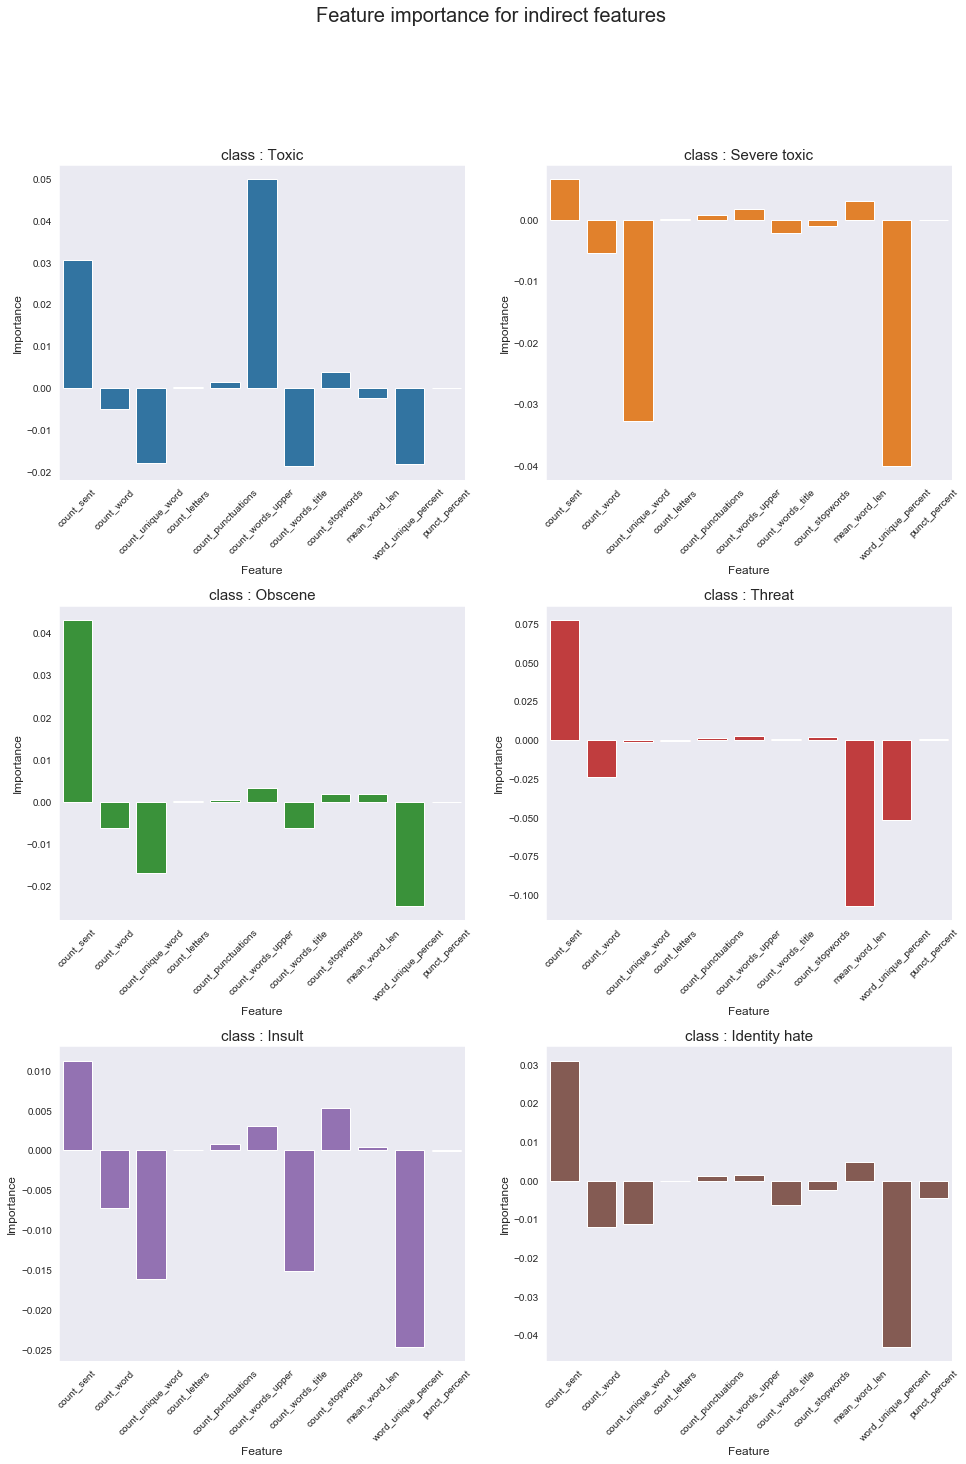

In [77]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

In [78]:
from scipy.sparse import csr_matrix, hstack

#Using all direct features
print("Using all features except leaky ones")
target_x = hstack((train_bigrams,train_charngrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()


end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time)

Using all features except leaky ones
total time till Sparse mat creation 1076.7072985172272


In [123]:
model = NbSvmClassifier(C=4, dual=False, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train[0:30000].shape[0], len(y_train[0:30000])))
preds_valid = np.zeros((X_valid[0:10000].shape[0], len(y_valid[0:10000])))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train[0:30000],y_train[0:30000][j])
    preds_valid[:,i] = model.predict_proba(X_valid[0:10000])[:,1]
    preds_train[:,i] = model.predict_proba(X_train[0:30000])[:,1]
    train_loss_class=log_loss(y_train[0:30000][j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[0:10000][j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)

Class:= toxic
Trainloss=log loss: 0.2212839498633659
Validloss=log loss: 0.21517752577794322
Class:= severe_toxic
Trainloss=log loss: 0.037730307339611
Validloss=log loss: 0.040795726841944914
Class:= obscene
Trainloss=log loss: 0.13333068930182204
Validloss=log loss: 0.12635619307083604
Class:= threat
Trainloss=log loss: 0.01749386321658598
Validloss=log loss: 0.016512836318021876
Class:= insult
Trainloss=log loss: 0.1352811973139952
Validloss=log loss: 0.133608798775415
Class:= identity_hate
Trainloss=log loss: 0.035147017096966444
Validloss=log loss: 0.04143912077155751
mean column-wise log loss:Train dataset 0.09671117068872442
mean column-wise log loss:Validation dataset 0.09564836692595309
total time till NB base model creation 48447.40383696556


# Topic Modeling:

Topic modeling can be a useful tool to summarize the context of a huge corpus(text) by guessing what the "Topic" or the general theme of the sentence.

This can also be used as inputs to our classifier if they can identify patterns or "Topics" that indicate toxicity.

Let's find out!

The steps followed in this kernel:

Preprocessing (Tokenization using gensim's simple_preprocess)

Cleaning

Stop word removal

Bigram collation

Lemmatization

Creation of dictionary (list of all words in the cleaned text)

Topic modeling using LDA

Visualization with pyLDAviz

Convert topics to sparse vectors

Feed sparse vectors to the model

In [92]:
#import required packages
#basic
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
import pyLDAvis.gensim
#nlp
import string
import re     #for regex
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


#Modeling
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy import sparse

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")

#constants
eng_stopwords = set(stopwords.words("english"))
#settings
warnings.filterwarnings("ignore")
lem = WordNetLemmatizer()
tokenizer=ToktokTokenizer()


%matplotlib inline

In [93]:
start_time=time.time()
#importing the dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
end_import=time.time()
print("Time till import:",end_import-start_time,"s")

Time till import: 2.9745452404022217 s


In [96]:
#to seperate sentenses into words
def preprocess(comment):
    """
    Function to build tokenized texts from input comment
    """
    return gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)


In [97]:
#tokenize the comments
train_text=train.comment_text.apply(lambda x: preprocess(x))
test_text=test.comment_text.apply(lambda x: preprocess(x))
all_text=train_text.append(test_text)
end_preprocess=time.time()
print("Time till pre-process:",end_preprocess-start_time,"s")

Time till pre-process: 240.40827989578247 s


In [98]:
print("Total number of comments:",len(all_text))
print("Before preprocessing:",train.comment_text.iloc[30])
print("After preprocessing:",all_text.iloc[30])

Total number of comments: 312735
Before preprocessing: How could I post before the block expires?  The funny thing is, you think I'm being uncivil!
After preprocessing: ['how', 'could', 'post', 'before', 'the', 'block', 'expires', 'the', 'funny', 'thing', 'you', 'think', 'being', 'uncivil']


In [99]:
#Phrases help us group together bigrams :  new + york --> new_york
bigram = gensim.models.Phrases(all_text)

In [100]:
bigram[all_text.iloc[30]]

['how',
 'could',
 'post',
 'before',
 'the',
 'block_expires',
 'the',
 'funny_thing',
 'you',
 'think',
 'being_uncivil']

In [101]:
def clean(word_list):
    """
    Function to clean the pre-processed word lists 
    
    Following transformations will be done
    1) Stop words removal from the nltk stopword list
    2) Bigram collation (Finding common bigrams and grouping them together using gensim.models.phrases)
    3) Lemmatization (Converting word to its root form : babies --> baby ; children --> child)
    """
    #remove stop words
    clean_words = [w for w in word_list if not w in eng_stopwords]
    #collect bigrams
    clean_words = bigram[clean_words]
    #Lemmatize
    clean_words=[lem.lemmatize(word, "v") for word in clean_words]
    return(clean_words) 

In [102]:
#check clean function
print("Before clean:",all_text.iloc[1])
print("After clean:",clean(all_text.iloc[1]))

Before clean: ['aww', 'matches', 'this', 'background', 'colour', 'seemingly', 'stuck', 'with', 'thanks', 'talk', 'january', 'utc']
After clean: ['aww', 'match', 'background', 'colour', 'seemingly', 'stick', 'thank', 'talk', 'january_utc']


In [103]:
#scale it to all text
all_text=all_text.apply(lambda x:clean(x))
end_clean=time.time()
print("Time till cleaning corpus:",end_clean-start_time,"s")    

Time till cleaning corpus: 643.7560575008392 s


In [104]:
#create the dictionary
dictionary = Dictionary(all_text)
print("There are",len(dictionary),"number of words in the final dictionary")



There are 322843 number of words in the final dictionary


In [105]:
#convert into lookup tuples within the dictionary using doc2bow
print(dictionary.doc2bow(all_text.iloc[1]))
print("Wordlist from the sentence:",all_text.iloc[1])
#to check
print("Wordlist from the dictionary lookup:", 
      dictionary[21],dictionary[22],dictionary[23],dictionary[24],dictionary[25],dictionary[26],dictionary[27])


[(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
Wordlist from the sentence: ['aww', 'match', 'background', 'colour', 'seemingly', 'stick', 'thank', 'talk', 'january_utc']
Wordlist from the dictionary lookup: aww background colour january_utc match seemingly stick


In [106]:
#scale it to all text
corpus = [dictionary.doc2bow(text) for text in all_text]
end_corpus=time.time()
print("Time till corpus creation:",end_clean-start_time,"s")

Time till corpus creation: 643.7560575008392 s


In [108]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1)],
 [(21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1)],
 [(2, 1),
  (12, 1),
  (16, 1),
  (28, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1)],
 [(8, 1),
  (11, 1),
  (34, 2),
  (41, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1)],
 [(81, 1), (82, 1), (83, 1), 

In [107]:
#create the LDA model
ldamodel = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary)
end_lda=time.time()
print("Time till LDA model creation:",end_lda-start_time,"s")    

Time till LDA model creation: 1123.9982533454895 s


In [111]:
pyLDAvis.enable_notebook()

In [112]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      25.411819        1       1  0.238032 -0.074848
5      14.630418        1       2  0.206042 -0.098596
11     12.390121        1       3  0.220125  0.100682
14      7.784705        1       4  0.156378  0.073723
2       6.429280        1       5  0.149071  0.149218
12      5.662569        1       6  0.045698 -0.191686
7       5.548033        1       7  0.069132 -0.156546
4       4.796633        1       8 -0.011843 -0.220151
0       3.863807        1       9 -0.081601 -0.203536
6       3.579438        1      10 -0.004515  0.220500
13      2.920746        1      11 -0.040266  0.209580
10      2.407094        1      12 -0.070514  0.216659
3       1.529452        1      13 -0.304680 -0.005537
1       1.527782        1      14 -0.294630 -0.011372
9       1.518112        1      15 -0.276430 -0.008090, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
46     Default  151437.000000      article  151437.000000  30.0000  30.0000
784    Default   38551.000000         fuck   38551.000000  29.0000  29.0000
79     Default   79297.000000    wikipedia   79297.000000  28.0000  28.0000
2      Default   60843.000000         edit   60843.000000  27.0000  27.0000
83     Default   75821.000000         page   75821.000000  26.0000  26.0000
3630   Default   18928.000000    fuck_fuck   18928.000000  25.0000  25.0000
168    Default   23762.000000        image   23762.000000  24.0000  24.0000
29     Default   45531.000000        thank   45531.000000  23.0000  23.0000
88     Default   63184.000000          use   63184.000000  22.0000  22.0000
1194   Default   31973.000000         name   31973.000000  21.0000  21.0000
11     Default   46366.000000       please   46366.000000  20.0000  20.0000
594    Default   23371.000000        block   23371.000000  19.0000  19.0000
201    Default   40959.000000       source   40959.000000  18.0000  18.0000
12     Default   27444.000000       remove   27444.000000  17.0000  17.0000
277    Default   55057.000000         like   55057.000000  16.0000  16.0000
206    Default   12451.000000          tag   12451.000000  15.0000  15.0000
154    Default   21375.000000       delete   21375.000000  14.0000  14.0000
301    Default   57968.000000          say   57968.000000  13.0000  13.0000
934    Default   40401.000000       people   40401.000000  12.0000  12.0000
130    Default   34623.000000          add   34623.000000  11.0000  11.0000
1111   Default    8501.000000         shit    8501.000000  10.0000  10.0000
403    Default   43861.000000          get   43861.000000   9.0000   9.0000
16     Default   21958.000000    talk_page   21958.000000   8.0000   8.0000
179    Default   24691.000000         link   24691.000000   7.0000   7.0000
14     Default   15408.000000       revert   15408.000000   6.0000   6.0000
5946   Default    7970.000000         suck    7970.000000   5.0000   5.0000
199    Default   54667.000000          see   54667.000000   4.0000   4.0000
456    Default   18736.000000         help   18736.000000   3.0000   3.0000
8      Default   59274.000000         make   59274.000000   2.0000   2.0000
73     Default   58552.000000        think   58552.000000   1.0000   1.0000
...        ...            ...          ...            ...      ...      ...
4287   Topic15    1057.948486        peter    1059.159302   4.1866  -4.8806
6919   Topic15    1064.259033       muslim    1065.485352   4.1866  -4.8746
1330   Topic15    1000.034241     episodes    1001.236633   4.1865  -4.9369
3943   Topic15     910.694092  much_better     911.896851   4.1864  -5.0305
4684   Topic15     889.793579         clue     890.995972   4.1864  -5.0537
723    Topic15     836.692139    terrorism     837.895691   4.1863  -5.1152
6915   Topic15     834.927979     division     836.146240   4.1862  -5.1173

In [110]:
end_viz=time.time()
print("Time till viz:",end_viz-start_time,"s")

Time till viz: 37043.98239326477 s


Chart Desc:

The above visuals are from the awesome pyLDAviz package which is the python version of R package LDAviz.

The Left side shows the multi-dimensional "word-space" superimposed on two "Principal components" and the relative positions of all the topics.

The size of the circle represents what % of the corpus it contains.

The right side shows the word frequencies within the topic and in the whole corpus.

Clearly, some of the topics show a pattern of toxicity (ie) have a high contribution from toxic words.

Now let's feed these topics into a model

In [113]:
#creating the topic probability matrix 
topic_probability_mat = ldamodel[corpus]

In [114]:
topic_probability_mat

In [115]:
#split it to test and train
train_matrix=topic_probability_mat[:train.shape[0]]
test_matrix=topic_probability_mat[train.shape[0]:]

In [116]:
del(topic_probability_mat)
del(corpus)
del(all_text)
gc.collect()

139

In [117]:
#convert to sparse format (Csr matrix)
train_sparse=gensim.matutils.corpus2csc(train_matrix)
test_sparse=gensim.matutils.corpus2csc(test_matrix)
end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time,"s")

total time till Sparse mat creation 47316.017668008804 s


In [118]:
#custom NB model
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    

model = NbSvmClassifier(C=2, dual=True, n_jobs=-1)

In [119]:
#set the target columns
target_x=train_sparse.transpose()
TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train[TARGET_COLS]

In [120]:
del(train_sparse)
gc.collect()

16

In [122]:
model = NbSvmClassifier(C=4, dual=False, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], y_train.shape[1]))
preds_valid = np.zeros((X_valid.shape[0], y_train.shape[1]))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)

Class:= toxic
Trainloss=log loss: 0.21782012010447147
Validloss=log loss: 0.21487923838209713
Class:= severe_toxic
Trainloss=log loss: 0.03742179832482115
Validloss=log loss: 0.03814143186504605
Class:= obscene
Trainloss=log loss: 0.13351833953542655
Validloss=log loss: 0.13137148351650263
Class:= threat
Trainloss=log loss: 0.016938831458497748
Validloss=log loss: 0.016544872885196675
Class:= insult
Trainloss=log loss: 0.13477642433392098
Validloss=log loss: 0.13396640426904835
Class:= identity_hate
Trainloss=log loss: 0.03728541279166669
Validloss=log loss: 0.039172700344574506
mean column-wise log loss:Train dataset 0.09629348775813408
mean column-wise log loss:Validation dataset 0.09567935521041089
total time till NB base model creation 48443.00518012047
